# Inter-comparison and validation against in-situ measurements of satellite estimates of incoming solar radiation for Indien Ocean at BSRN site (RE)

**Auteur :**  GRONDIN Erwan

**Date :**  05/06/2024

---

# Les nouvelles commandes apprises

+ mettre une texte en gras : `fontweight='bold'`



---

In [132]:
# library
import glob
import os
import seaborn as sns
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pvlib
from pvlib.location import Location
from pandas.plotting import register_matplotlib_converters
import plotly.graph_objects as go
import xarray as xr
import netCDF4 as nc
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.signal import savgol_filter
from sklearn.cluster import KMeans as KM
import warnings

#############################################################################################################
# Désactiver l'affichage des FutureWarnings temporairement
warnings.simplefilter(action='ignore', category=FutureWarning)
#############################################################################################################

#############################################################################################################
#sns.set(style="darkgrid", palette="bright",context = "paper",font="Arial" )
sns.set(style="darkgrid", palette="bright",context = "talk",font="Arial" )
#############################################################################################################

#############################################################################################################
def hourly_mean(df):
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    
    # Filtrer les heures UTC entre 02h et 14h (inclus)
    df_filtered = data.between_time('02:00', '14:00')
    # Group data by hour and calculate the mean
    df_hourly_mean = df_filtered.resample('H').mean()
    return df_hourly_mean
#############################################################################################################
def daily_mean(df):
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    
    # Filtrer les heures entre 01h et 15h (inclus)
    df_filtered = data.between_time('02:00', '14:00')
    # Group data by hour and calculate the mean
    df_daily_mean = df_filtered.resample('D').mean()
    return df_daily_mean


#############################################################################################################
def monthly_mean(df):
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    # Group data by hour and calculate the mean
    df_mounthly_mean = data.resample('M').mean()
    return df_mounthly_mean


#############################################################################################################
def yearly_mean(df):
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    # Group data by hour and calculate the mean
    df_yearly_mean = data.resample('Y').mean()
    return df_yearly_mean


#############################################################################################################
def count_nan(df):
    """
    Count the number of np.nan values in a DataFrame.

    Args :
        df (DataFrame) : pandas DataFrame

    Returns :
        count (Integer) : Number of np.nan values
    """
    # Count the number of np.nan in the DataFrame
    count = df.isnull().sum().sum()
    
    return count

#############################################################################################################
def Savitzky_Golay_filter(data, variable, WL ,PO):
    '''
    Input :
        data (dataframe) : datframe contains irradiance data
        variable (str) : name of column who you would like to smooth
    Return:
        df (dataframe) : dataframe filter with Savitzky-Golay
    '''
    
    df_1 = data.copy()
    df_2 = pd.DataFrame(df_1[variable])
    int_nan_value = count_nan(df_2) # nombre de valeur manquante avant la selection entre 02H et 14H
    print("Le nombre de valeurs NaN avant la sélection :",int_nan_value)
    df_2.index = pd.to_datetime(df_2.index)
    df_filtered = df_2.between_time('02:00', '14:00')

    df_cleaned = df_filtered.dropna(how='all')
    
    final_nan_value = count_nan(df_filtered) # nombre de valeur manquante après la selection entre 02H et 14H
    print("Le nombre de valeurs NaN après la sélection :",final_nan_value)


    smoothed_data = savgol_filter(df_cleaned[variable], WL, PO)
    df_cleaned_cop = df_cleaned.copy()
    df_cleaned_cop[f'{variable}_smoothed'] = smoothed_data
    df = df_cleaned_cop.clip(lower=0)
    df.index = pd.to_datetime(df.index)

    return df

#############################################################################################################
def formalisation_data(data_filter):
    mydf = data_filter.copy()
    # Supprimer le nom de l'index de la copie
    mydf.index.name = None
    mydf.index = pd.to_datetime(mydf.index)
    mydf = mydf.reset_index()
    mydf = mydf.rename(columns={'index': 'timestamp'})
    #mydf = mydf.rename(columns={variable: 'SIS_filtred'})
    mydf['date'] = mydf['timestamp'].dt.strftime('%Y/%m/%d')
    mydf['date'] = pd.to_datetime(mydf['date'], format='%Y/%m/%d')
    mydf['heure'] = mydf['timestamp'].dt.strftime('%H:%M:%S')
    mydf['ID'] =  ['D{}'.format(i + 1) for i in mydf.index]
    # Trouver la première date
    first_date = mydf['date'].min()
    # Calculer le nombre de jours écoulés depuis la première date
    mydf['ID_date'] = (mydf['date'] - first_date).dt.days + 1
    mydf2 = mydf.pivot_table(values='ghi',index='heure',columns='ID_date')
    return round(mydf2,3)

#############################################################################################################
def scaled_data(data_filter,variable):
    mydf = data_filter.copy()
    mydf.index = pd.to_datetime(mydf.index)
    mydf = mydf.reset_index()
    mydf = mydf.rename(columns={'index': 'timestamp'})
    #mydf = mydf.rename(columns={variable: 'SIS_filtred'})
    mydf['date'] = mydf['timestamp'].dt.strftime('%Y/%m/%d')
    mydf['date'] = pd.to_datetime(mydf['date'], format='%Y/%m/%d')
    mydf['heure'] = mydf['timestamp'].dt.strftime('%H:%M:%S')
    mydf['ID'] =  ['D{}'.format(i + 1) for i in mydf.index]
    # Trouver la première date
    first_date = mydf['date'].min()
    # Calculer le nombre de jours écoulés depuis la première date
    mydf['ID_date'] = (mydf['date'] - first_date).dt.days + 1
    mydf2 = mydf.pivot_table(values=variable,index='heure',columns='ID_date')
    scaled_mydf2 = (mydf2 - mydf2.mean(axis = 0))
    scaled_mydf2_without_NaN = scaled_mydf2.dropna(axis=1, how='any')
    return scaled_mydf2 , scaled_mydf2_without_NaN

# Useful data

In [21]:
#######################################  Geographical data ######################################################################
data_geo = pd.read_csv('data_geo_adaptation.csv', sep=';', index_col=0)

In [4]:
#######################################  SARAH ######################################################################
df_sarah_DNI = pd.read_csv('data_urmoufia/data_UTC/SARAH_3_DNI_moufia.csv', sep=';', index_col=0)
df_sarah_GHI = pd.read_csv('data_urmoufia/data_UTC/SARAH_3_SIS_moufia.csv', sep=';', index_col=0)

#######################################  IN-SITU ######################################################################
df_urmoufia = pd.read_csv('data_urmoufia/data_UTC/urmoufia.csv', sep=';', index_col=0)
df_BSRN = pd.read_csv('data_urmoufia/data_UTC/BSRN_data_2016_08_01_to_2024_04_01.csv', sep=';', index_col=0)

In [15]:
df_urmoufia

,ghi,dhi,dni_ground,SZA,extra_radiation,mu0,dni,physical_limit_ghi,physical_limit_dhi,physical_limit_dni
2008-12-01 00:00:00,NaN,NaN,NaN,108.900321,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:01:00,NaN,NaN,NaN,108.705327,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:02:00,NaN,NaN,NaN,108.510036,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:03:00,NaN,NaN,NaN,108.314451,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:04:00,NaN,NaN,NaN,108.118574,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
...,...,...,...,...,...,...,...,...,...,...
2023-10-13 23:55:00,NaN,NaN,NaN,116.430864,1372.582131,0.1,NaN,229.906116,132.273874,1372.582131
2023-10-13 23:56:00,NaN,NaN,NaN,116.212317,1372.582131,0.1,NaN,229.906116,132.273874,1372.582131
2023-10-13 23:57:00,NaN,NaN,NaN,115.993582,1372.582131,0.1,NaN,229.906116,132.273874,1372.582131
2023-10-13 23:58:00,NaN,NaN,NaN,115.774664,1372.582131,0.1,NaN,229.906116,132.273874,1372.582131


# Utilisation du même pas de temps que CM-SAF

In [18]:
#############################################################################################################
def instantaneous_ios_data(df):
    data = df.copy() #copy dataframe
    data.index = pd.to_datetime(data.index) #convert index of dataframe to datetime 
    df_urmoufia_30min = data.resample('30T').first() #select data every 30 minutes
    #Filtrer les heures UTC entre 02h et 14h (inclus)
    df_filtered = df_urmoufia_30min.between_time('02:00', '14:00')
    return round(df_filtered,3) #round data with 3 digits
#############################################################################################################

In [17]:
df_urmoufia_30min = instantaneous_ios_data(df_urmoufia)
df_urmoufia_30min

,ghi,dhi,dni_ground,SZA,extra_radiation,mu0,dni,physical_limit_ghi,physical_limit_dhi,physical_limit_dni
2008-12-01 02:00:00,NaN,NaN,NaN,83.923,1406.452,0.106,NaN,242.542,140.277,1406.452
2008-12-01 02:30:00,NaN,NaN,NaN,77.337,1406.452,0.219,NaN,441.408,266.225,1406.452
2008-12-01 03:00:00,NaN,NaN,NaN,70.665,1406.452,0.331,NaN,659.948,404.633,1406.452
2008-12-01 03:30:00,NaN,NaN,NaN,63.924,1406.452,0.440,NaN,886.747,548.273,1406.452
2008-12-01 04:00:00,NaN,NaN,NaN,57.127,1406.452,0.543,NaN,1113.355,691.792,1406.452
...,...,...,...,...,...,...,...,...,...,...
2023-10-13 12:00:00,NaN,NaN,NaN,58.250,1372.582,0.526,NaN,1052.834,653.462,1372.582
2023-10-13 12:30:00,NaN,NaN,NaN,65.249,1372.582,0.419,NaN,824.238,508.684,1372.582
2023-10-13 13:00:00,NaN,NaN,NaN,72.253,1372.582,0.305,NaN,594.835,363.396,1372.582
2023-10-13 13:30:00,NaN,NaN,NaN,79.248,1372.582,0.187,NaN,374.537,223.874,1372.582


In [40]:
data_geo

,Latitude,Longitude,Altitude,Latitude_modif,Longitude_modif
amitie,-4.321022,55.693360,3.00,-4.325,55.675
anseboileau,-4.710958,55.484734,2.00,-4.725,55.475
antananarivo,-18.898330,47.546420,1309.00,-18.875,47.525
aurere,-21.019772,55.424725,603.00,-21.025,55.425
braspanonmoreau,-21.002650,55.682896,20.00,-21.025,55.675
cavernedufour,-21.109177,55.495655,2495.00,-21.125,55.475
cilaosbrassec,-21.141754,55.489704,1269.00,-21.125,55.475
cilaospiscine,-21.136158,55.474160,1213.00,-21.125,55.475
cilaosthermes,-21.128940,55.473320,1255.80,-21.125,55.475
craterebory,-21.244139,55.709020,2584.20,-21.225,55.725


# Creat clear sky model

In [20]:
import pandas as pd
from pvlib import location
from pvlib.bifacial.pvfactors import pvfactors_timeseries
import matplotlib.pyplot as plt
import warnings

# supressing shapely warnings that occur on import of pvfactors
warnings.filterwarnings(action='ignore', module='pvfactors')


In [38]:
#times = pd.date_range('2021-06-21', '2021-06-22', freq='30T', tz='Indian/Reunion')
times = df_urmoufia_30min.index.tz_localize('UTC')
loc = location.Location(latitude=-20.925, longitude=55.475, tz=times.tz)
sp = loc.get_solarposition(times,temperature=25) #with 25°C same mean température à La Réunion
cs = loc.get_clearsky(times,model='haurwitz',solar_position=sp) # model 'haurwitz' -> ghi ; 'ineichen' -> ghi,dhi,dni

In [35]:
sp

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2008-12-01 02:00:00+00:00,83.789810,83.921739,6.210190,6.078261,111.085828,10.986005
2008-12-01 02:30:00+00:00,77.267936,77.336758,12.732064,12.663242,108.802469,10.978168
2008-12-01 03:00:00+00:00,70.621025,70.666122,19.378975,19.333878,106.738101,10.970326
2008-12-01 03:30:00+00:00,63.893444,63.926065,26.106556,26.073935,104.859018,10.962480
2008-12-01 04:00:00+00:00,57.104800,57.129606,32.895200,32.870394,103.140058,10.954629
...,...,...,...,...,...,...
2023-10-13 12:00:00+00:00,58.218138,58.244022,31.781862,31.755978,273.800754,13.711563
2023-10-13 12:30:00+00:00,65.206863,65.241433,24.793137,24.758567,270.953634,13.716582
2023-10-13 13:00:00+00:00,72.195436,72.244680,17.804564,17.755320,268.281576,13.721597
2023-10-13 13:30:00+00:00,79.158092,79.238339,10.841908,10.761661,265.685441,13.726609


In [39]:
cs

,ghi
2008-12-01 02:00:00+00:00,68.844116
2008-12-01 02:30:00+00:00,185.155101
2008-12-01 03:00:00+00:00,304.983596
2008-12-01 03:30:00+00:00,422.539198
2008-12-01 04:00:00+00:00,534.941063
...,...
2023-10-13 12:00:00+00:00,517.016716
2023-10-13 12:30:00+00:00,400.007858
2023-10-13 13:00:00+00:00,276.821398
2023-10-13 13:30:00+00:00,150.927466


<Axes: >

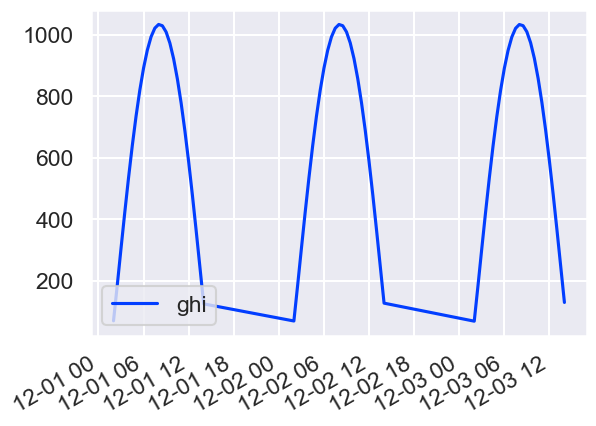

In [37]:
cs['2008-12-01':'2008-12-03'].plot()

In [83]:
#############################################################################################################
def formalisation_data(data_filter):
    mydf = data_filter.copy()
    # Supprimer le nom de l'index de la copie
    mydf.index.name = None
    mydf.index = pd.to_datetime(mydf.index)
    mydf = mydf.reset_index()
    mydf = mydf.rename(columns={'index': 'timestamp'})
    #mydf = mydf.rename(columns={variable: 'SIS_filtred'})
    mydf['date'] = mydf['timestamp'].dt.strftime('%Y/%m/%d')
    mydf['date'] = pd.to_datetime(mydf['date'], format='%Y/%m/%d')
    mydf['heure'] = mydf['timestamp'].dt.strftime('%H:%M:%S')
    mydf['ID'] =  ['D{}'.format(i + 1) for i in mydf.index]
    # Trouver la première date
    first_date = mydf['date'].min()
    # Calculer le nombre de jours écoulés depuis la première date
    mydf['ID_date'] = (mydf['date'] - first_date).dt.days + 1
    mydf2 = mydf.pivot_table(values='ghi',index='heure',columns='ID_date')
    return round(mydf2,3)

#############################################################################################################
df_summer = cs[cs.index.month.isin([11, 12, 1, 2,3,4])]
df_winter = cs[cs.index.month.isin([5, 6, 7, 8,9,10])]

formalis_summer_data = formalisation_data(df_summer)
formalis_winter_data = formalisation_data(df_winter)


In [89]:
formalis_summer_data.head()

ID_date,1,2,3,4,5,6,7,8,9,10,...,5255,5256,5257,5258,5259,5260,5261,5262,5263,5264
heure,,,,,,,,,,,,,,,,,,,,,
02:00:00,68.844,68.321,67.723,67.052,66.310,65.498,64.617,63.669,62.657,61.581,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
02:30:00,185.155,184.460,183.687,182.838,181.915,180.919,179.852,178.714,177.509,176.236,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
03:00:00,304.984,304.179,303.301,302.352,301.332,300.244,299.089,297.869,296.585,295.239,...,61.416,59.993,58.565,57.131,55.694,54.252,52.808,51.361,49.912,48.463
03:30:00,422.539,421.663,420.719,419.710,418.636,417.500,416.302,415.046,413.732,412.361,...,179.531,177.763,175.983,174.190,172.386,170.570,168.743,166.907,165.061,163.206
04:00:00,534.941,534.027,533.052,532.018,530.926,529.778,528.576,527.321,526.015,524.659,...,298.178,296.182,294.171,292.147,290.109,288.058,285.996,283.922,281.838,279.745


In [90]:
formalis_winter_data.head()

ID_date,1,2,3,4,5,6,7,8,9,10,...,5270,5271,5272,5273,5274,5275,5276,5277,5278,5279
heure,,,,,,,,,,,,,,,,,,,,,
02:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.015,0.109,0.369,0.853,1.583,2.556,3.752,5.147,6.715
02:30:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,82.094,85.654,89.194,92.711,96.199,99.657,103.080,106.466,109.811,113.113
03:00:00,46.472,45.022,43.574,42.128,40.687,39.250,37.819,36.395,34.978,33.570,...,206.897,210.627,214.314,217.956,221.551,225.096,228.590,232.029,235.413,238.738
03:30:00,160.640,158.765,156.883,154.996,153.105,151.208,149.309,147.406,145.501,143.594,...,332.239,335.909,339.530,343.098,346.612,350.070,353.470,356.809,360.087,363.302
04:00:00,276.844,274.730,272.609,270.484,268.354,266.220,264.083,261.944,259.805,257.665,...,452.676,456.231,459.730,463.173,466.556,469.880,473.141,476.339,479.471,482.537


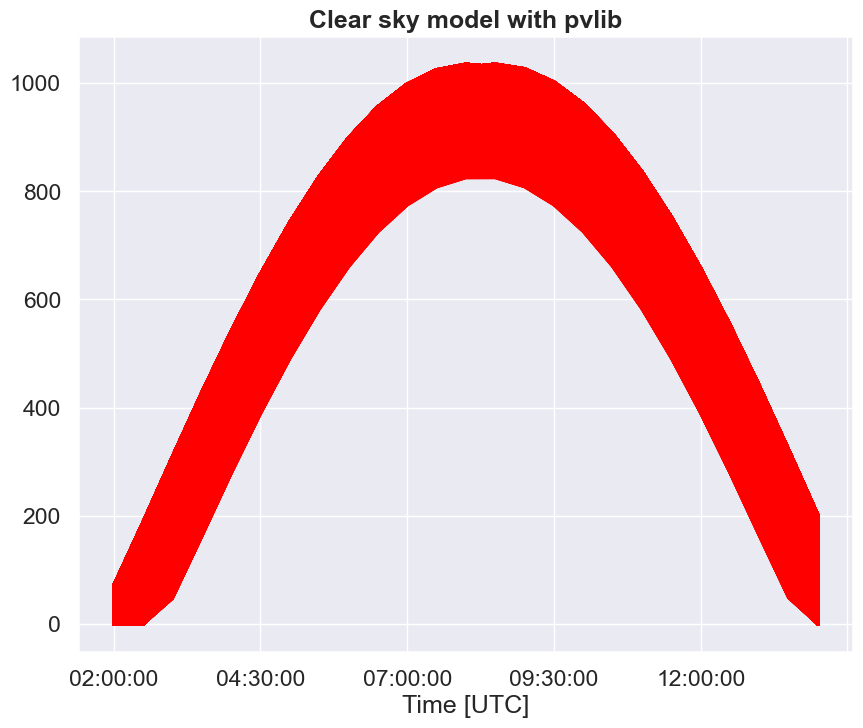

In [86]:
# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
formalis_summer_data.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()

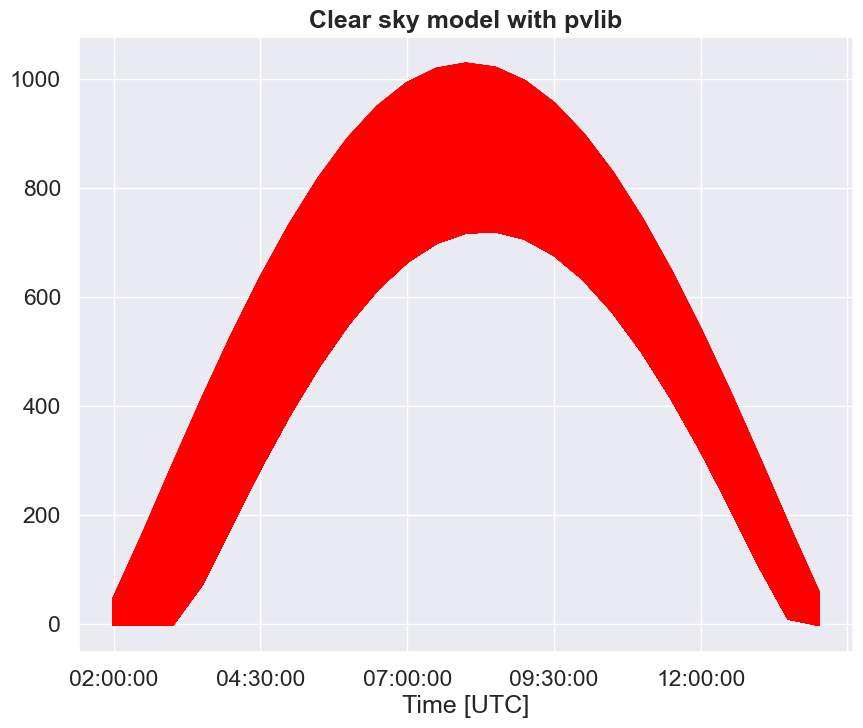

In [87]:
# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
formalis_winter_data.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()

# Found the trend curve

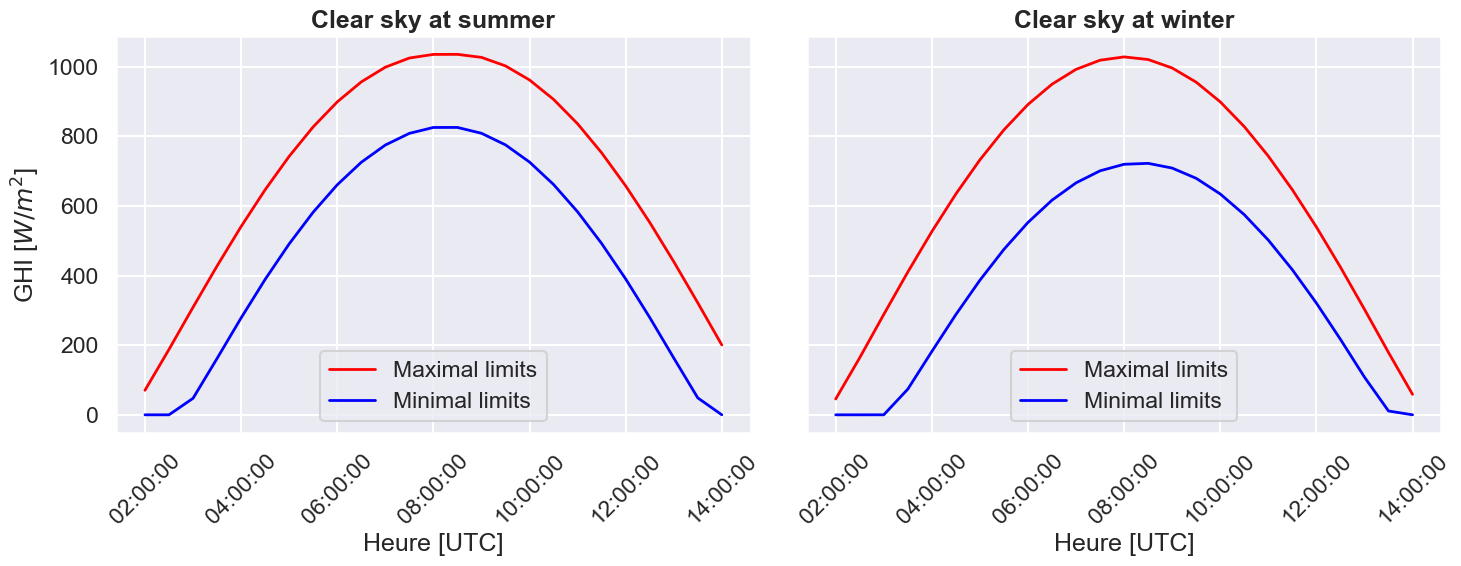

In [115]:
#----- summer
trend_max_summer = formalis_summer_data.max(axis=1).tolist()
trend_min_summer = formalis_summer_data.min(axis=1).tolist()
#----- winter
trend_max_winter = formalis_winter_data.max(axis=1).tolist()
trend_min_winter = formalis_winter_data.min(axis=1).tolist()


fig, axes = plt.subplots(1, 2, figsize=(15, 6),sharey=True)

# Tracer les données sur chaque sous-graphe
axes[0].plot(formalis_summer_data.index, trend_max_summer,lw = 2,color='red',label ='Maximal limits')
axes[0].plot(formalis_summer_data.index, trend_min_summer,lw = 2,color='blue',label ='Minimal limits')
axes[0].set_title('Clear sky at summer',  fontweight='bold')
axes[0].set_xlabel('Heure [UTC]')
axes[0].set_ylabel('GHI [$W/m^2$]')
axes[0].legend()

# Tracer les données sur chaque sous-graphe
axes[1].plot(formalis_summer_data.index, trend_max_winter,lw = 2,color='red',label ='Maximal limits')
axes[1].plot(formalis_summer_data.index, trend_min_winter,lw = 2,color='blue',label ='Minimal limits')
axes[1].set_title('Clear sky at winter',  fontweight='bold')
axes[1].set_xlabel('Heure [UTC]')
axes[1].legend()

# Pour chaque sous-graphique, ajustez les étiquettes de l'axe x
axes[0].set_xticks(formalis_summer_data.index[::4])  # Affiche une étiquette sur 4
axes[1].set_xticks(formalis_summer_data.index[::4])  # Affiche une étiquette sur 4

# Rotation des étiquettes pour éviter le chevauchement
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

plt.xticks(rotation=45)
# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()


# Apply clear sky classification

In [120]:
df_urmoufia_summer = df_urmoufia_30min[df_urmoufia_30min.index.month.isin([11, 12, 1, 2, 3, 4])]
df_urmoufia_winter = df_urmoufia_30min[df_urmoufia_30min.index.month.isin([5, 6, 7, 8, 9, 10])]
df_urmoufia_summer

,ghi,dhi,dni_ground,SZA,extra_radiation,mu0,dni,physical_limit_ghi,physical_limit_dhi,physical_limit_dni
2008-12-01 02:00:00,NaN,NaN,NaN,83.923,1406.452,0.106,NaN,242.542,140.277,1406.452
2008-12-01 02:30:00,NaN,NaN,NaN,77.337,1406.452,0.219,NaN,441.408,266.225,1406.452
2008-12-01 03:00:00,NaN,NaN,NaN,70.665,1406.452,0.331,NaN,659.948,404.633,1406.452
2008-12-01 03:30:00,NaN,NaN,NaN,63.924,1406.452,0.440,NaN,886.747,548.273,1406.452
2008-12-01 04:00:00,NaN,NaN,NaN,57.127,1406.452,0.543,NaN,1113.355,691.792,1406.452
...,...,...,...,...,...,...,...,...,...,...
2023-04-30 12:00:00,45.420,46.550,NaN,65.679,1345.658,0.412,-2.744,796.171,490.909,1345.658
2023-04-30 12:30:00,10.360,9.830,NaN,71.968,1345.658,0.310,1.712,594.198,362.992,1345.658
2023-04-30 13:00:00,10.210,9.930,NaN,78.440,1345.658,0.200,1.397,393.287,235.748,1345.658
2023-04-30 13:30:00,3.004,2.396,NaN,85.051,1345.658,0.100,6.080,227.358,130.660,1345.658


Le nombre de valeurs NaN avant la sélection : 6528
Le nombre de valeurs NaN après la sélection : 6528
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2373
Nombre de journée de ciel clair : 11


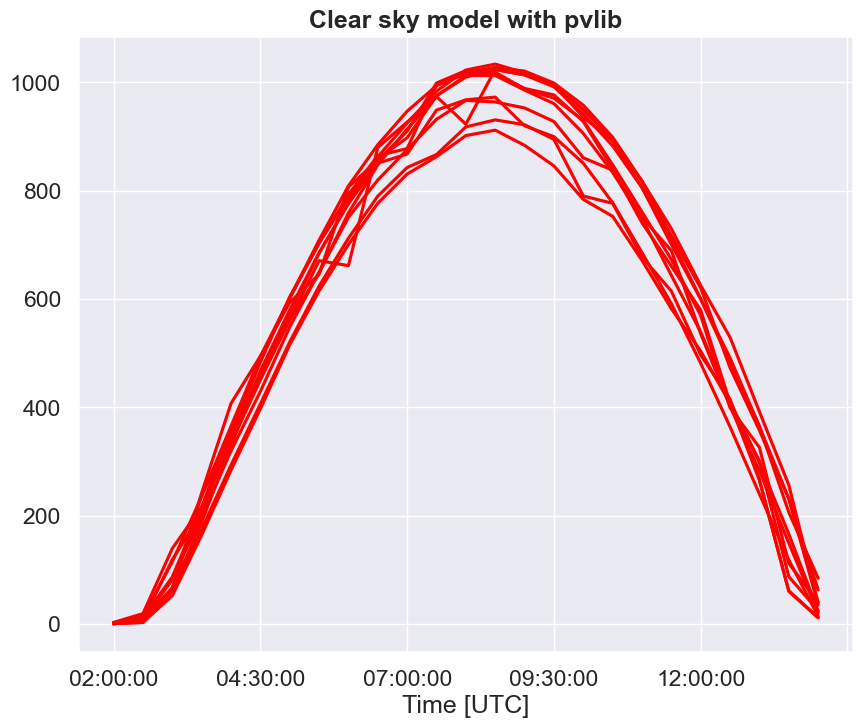

In [133]:
data , variable, trend_min,trend_max = df_urmoufia_summer, 'ghi',trend_min_summer,trend_max_summer

df = data.copy()
df_filter = Savitzky_Golay_filter(df, variable, 5 , 2)
print(df_filter.columns)
df_summer_form = formalisation_data(df_filter)
mydf = df_summer_form.dropna(axis=1, how='any')

nb_tot_day = mydf.shape[1]
print('Nombre de journée valide à l''analyse :',nb_tot_day)

selected_columns_sun_day = []
# Parcourir les colonnes de votre DataFrame
for col in mydf.columns:
    ghi_values = mydf[col].values
    # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
    if np.all((ghi_values >= trend_min) & (ghi_values <= trend_max)):
        selected_columns_sun_day.append(col)
df_sun_days = mydf.loc[:, selected_columns_sun_day]
nb_sun_day = len(selected_columns_sun_day)
print('Nombre de journée de ciel clair :',nb_sun_day)


# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
df_sun_days.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()

Le nombre de valeurs NaN avant la sélection : 2430
Le nombre de valeurs NaN après la sélection : 2430
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2594
Nombre de journée de ciel clair : 52


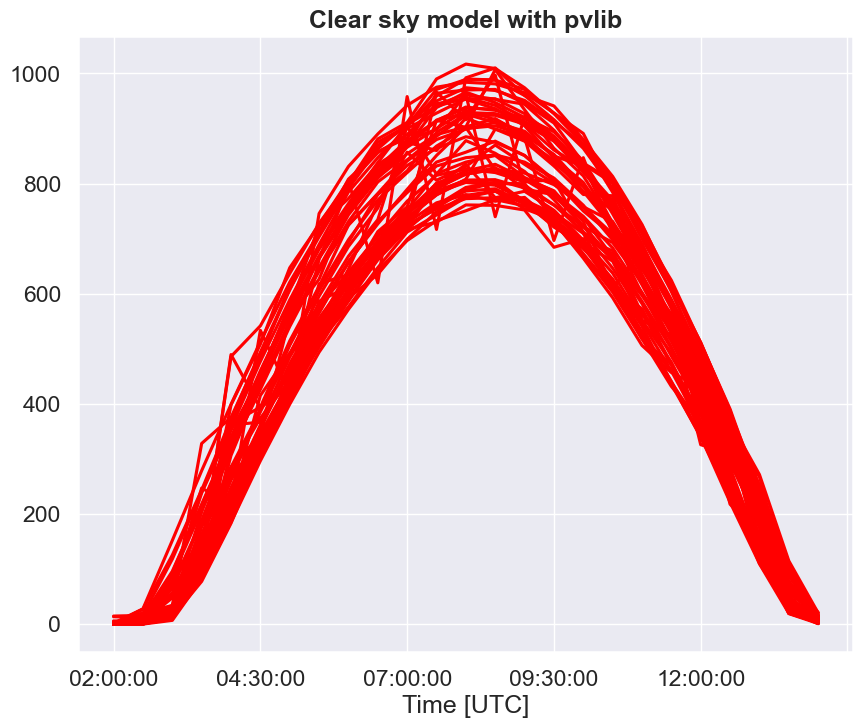

In [134]:
data , variable, trend_min,trend_max = df_urmoufia_winter, 'ghi',trend_min_winter,trend_max_winter

df = data.copy()
df_filter = Savitzky_Golay_filter(df, variable, 5 , 2)
print(df_filter.columns)
df_summer_form = formalisation_data(df_filter)
mydf = df_summer_form.dropna(axis=1, how='any')

nb_tot_day = mydf.shape[1]
print('Nombre de journée valide à l''analyse :',nb_tot_day)

selected_columns_sun_day = []
# Parcourir les colonnes de votre DataFrame
for col in mydf.columns:
    ghi_values = mydf[col].values
    # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
    if np.all((ghi_values >= trend_min) & (ghi_values <= trend_max)):
        selected_columns_sun_day.append(col)
df_sun_days = mydf.loc[:, selected_columns_sun_day]
nb_sun_day = len(selected_columns_sun_day)
print('Nombre de journée de ciel clair :',nb_sun_day)


# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
df_sun_days.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()